# 语言模型和数据集

## 1. 学习语言模型
显⽽易⻅，我们⾯对的问题是如何对⼀个⽂档，甚⾄是⼀个词元序列进⾏建模。假设在单词级别对⽂本数据
进⾏词元化，我们可以依靠之前对序列模型的分析。让我们从基本概率规则开始：
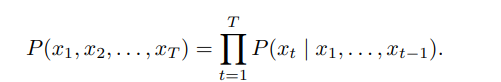
例如，包含了四个单词的⼀个⽂本序列的概率是：
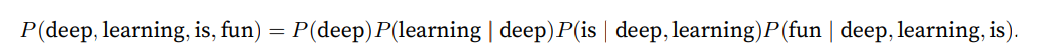

为了训练语⾔模型，我们需要计算单词的概率，以及给定前⾯⼏个单词后出现某个单词的条件概率。这些概率本质上就是语⾔模型的参数。


## 2. 自然语言统计

In [1]:
import random
import torch
from d2l import torch as d2l

In [2]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个⽂本⾏不⼀定是⼀个句⼦或⼀个段落，因此我们把所有⽂本⾏拼接到⼀起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus) # 词汇表
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

正如我们所看到的，最流⾏的词看起来很⽆聊，这些词通常被称为停⽤词（stop words），因此可以被过滤掉。尽管如此，它们本⾝仍然是有意义的，我们仍然会在模型中使⽤它们。此外，还有个明显的问题是词频衰减的速度相当地快。例如，最常⽤单词的词频对⽐，第10个还不到第1个的1/5。为了更好地理解，我们可以画
出的词频图：


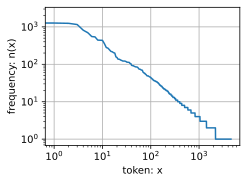

In [3]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
        xscale='log', yscale='log')

通过此图我们可以发现：词频以⼀种明确的⽅式迅速衰减。将前⼏个单词作为例外消除后，剩余的所有单词⼤致遵循双对数坐标图上的⼀条直线。这意味着单词的频率满⾜⻬普夫定律,即第i个最常⽤
单词的频率ni为:
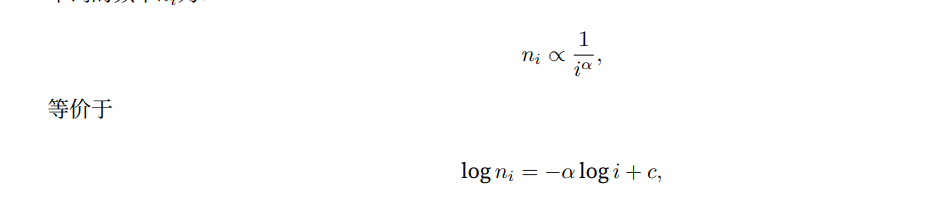
其中α是刻画分布的指数，c是常数。这告诉我们想要通过计数统计和平滑来建模单词是不可⾏的，因为这样
建模的结果会⼤⼤⾼估尾部单词的频率，也就是所谓的不常⽤单词。  

我们来看看⼆元语法的频率是否与⼀元语法的频率表现出相同的⾏为⽅式。

In [5]:
# 二元词汇
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [6]:
# 三元语法
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:]
)]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

直观对比一元语法，二元语法，三元语法

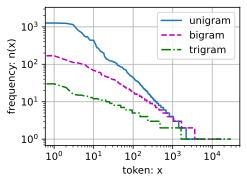

In [7]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
        ylabel='frequency: n(x)', xscale='log', yscale='log',
        legend=['unigram', 'bigram', 'trigram'])

这张图⾮常令⼈振奋！原因有很多：
+ 1. 除了⼀元语法词，单词序列似乎也遵循⻬普夫定律，尽管公式 中的指数α更⼩（指数的⼤⼩受序列⻓度的影响）；
+ 2. 词表中n元组的数量并没有那么⼤，这说明语⾔中存在相当多的结构，这些结构给了我们应⽤模型的希望；
+ 3. 很多n元组很少出现，这使得拉普拉斯平滑⾮常不适合语⾔建模。作为代替，我们将使⽤基于深度学习的模型。


## 3. 读取长序列数据
我们可以从随机偏移量开始划分序列，以同时获得覆盖性（coverage）和随机性（randomness）。下⾯，我们将描述如何实现随机采样（random sampling）和 顺序分区（sequential partitioning）策略。


+ 随机采样   
在随机采样中，每个样本都是在原始的⻓序列上任意捕获的⼦序列。在迭代过程中，来⾃两个相邻的、随机的、⼩批量中的⼦序列不⼀定在原始序列上相邻。对于语⾔建模，⽬标是基于到⽬前为⽌我们看到的词元来预测下⼀个词元，因此标签是移位了⼀个词元的原始序列。


In [12]:
def seq_data_iter_random(corpus, batch_size, num_steps): #@save
    """使⽤随机抽样⽣成⼀个⼩批量⼦序列"""
    # 从随机偏移量开始对序列进⾏分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps-1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # ⻓度为num_steps的⼦序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来⾃两个相邻的、随机的、⼩批量中的⼦序列不⼀定在原始序列上相邻
    random.shuffle(initial_indices)
    
    def data(pos):
        # 返回从pos位置开始的⻓度为num_steps的序列
        return corpus[pos: pos + num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这⾥，initial_indices包含⼦序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [13]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY: ', Y)

X:  tensor([[26, 27, 28, 29, 30],
        [16, 17, 18, 19, 20]]) 
Y:  tensor([[27, 28, 29, 30, 31],
        [17, 18, 19, 20, 21]])
X:  tensor([[11, 12, 13, 14, 15],
        [ 1,  2,  3,  4,  5]]) 
Y:  tensor([[12, 13, 14, 15, 16],
        [ 2,  3,  4,  5,  6]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [21, 22, 23, 24, 25]]) 
Y:  tensor([[ 7,  8,  9, 10, 11],
        [22, 23, 24, 25, 26]])


+ 顺序分区   
在迭代过程中，除了对原始序列可以随机抽样外，我们还可以保证两个相邻的⼩批量中的⼦序列在原始序列上也是相邻的。这种策略在基于⼩批量的迭代过程中保留了拆分的⼦序列的顺序，因此称为顺序分区。


In [18]:
def seq_data_iter_sequential(corpus, batch_size, num_steps): #@save
    """使⽤顺序分区⽣成⼀个⼩批量⼦序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y


In [19]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY: ', Y)

X:  tensor([[ 0,  1,  2,  3,  4],
        [17, 18, 19, 20, 21]]) 
Y:  tensor([[ 1,  2,  3,  4,  5],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 5,  6,  7,  8,  9],
        [22, 23, 24, 25, 26]]) 
Y:  tensor([[ 6,  7,  8,  9, 10],
        [23, 24, 25, 26, 27]])
X:  tensor([[10, 11, 12, 13, 14],
        [27, 28, 29, 30, 31]]) 
Y:  tensor([[11, 12, 13, 14, 15],
        [28, 29, 30, 31, 32]])


In [20]:
class SeqDataLoader: #@save
    
    def __init__(self, batch_size, num_steps, user_random_iter, max_tokens):
        if user_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.num_steps = batch_size, num_steps
    
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [21]:
def load_data_time_machine(batch_size, num_steps, #@save
                          use_random_iter=False, max_tokens=10000):
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens
    )
    return data_iter, data_iter.vocab